In [87]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


2575


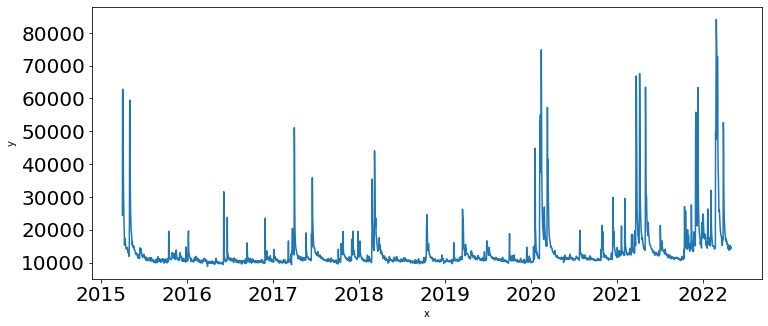

In [88]:
# Prepare DATA
RED_obs = pd.read_csv("RED_Observed.csv")
RED_BOM = pd.read_csv("RED_Rainfall.csv")

# Set date as index and convert to datetime
RED_obs.set_index('Date',inplace=True)
RED_obs.index = pd.to_datetime(RED_obs.index, infer_datetime_format=True).astype('datetime64[ns]')

# Convert columns to numbers
RED_obs['Rainfall'] = pd.to_numeric(RED_obs['Rainfall'], errors='coerce')
RED_obs['Inflow'] = pd.to_numeric(RED_obs['Inflow'], errors='coerce')
RED_obs['Inflow'].fillna(method='ffill', inplace=True)

# Convert date columns to a single datetime and set as index then remove the leftover columns
RED_BOM['Date'] = pd.to_datetime(RED_BOM[['Year','Month','Day']])
RED_BOM.set_index('Date',inplace=True)
RED_BOM.drop(['Year','Month','Day', 'Period over which rainfall was measured (days)', 'Quality'], axis=1, inplace=True)

RED_BOM.rename(columns = {'Rainfall amount (millimetres)': 'Rainfall'},inplace=True)
RED_BOM.dropna(inplace=True)

# Combine the RED_BOM and RED_obs into one df

df = RED_obs.join(RED_BOM, lsuffix='_obs', rsuffix='_BOM') # Left Join on RED_obs
df['Rainfall_BOM'].fillna(method='ffill', inplace=True)
df.dropna(inplace=True)



dates = df.index.values
N = len(df['Inflow'])
x = df.index.values
y = df['Inflow'].values.astype(np.float32)

print(len(y))

plt.figure(figsize=(12,5))
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y)

In [ ]:
# Create parameters

N = 100
L = 1000
T = 20

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:],'r', linewidth=2.0)
plt.show()

In [115]:
# LSTM Class

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []
        n_samples = 1

        h_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1,dim=0):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=0)
        return outputs



In [90]:
# Convert training data into tensors
train_input = torch.tensor(y[:-100]) # 2475
train_target = torch.tensor(y[1:-99]) # 2474
test_input = torch.tensor(y[-101:-1:]) # 100
test_target = torch.tensor(y[-100:]) # 100

In [116]:
# Training Loop
model = LSTMPredictor()
criterion = nn.MSELoss()

optimizer = optim.LBFGS(model.parameters(), lr=0.8)
train_losses = {}
test_losses = {}

n_steps = 25
for i in range(n_steps):
    print("Step", i)

    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss

    optimizer.step(closure)

    train_losses[i] = loss.item()

    with torch.no_grad():
        future=365
        pred = model(test_input, future=future)
        loss = criterion(pred[:-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().numpy()

    test_losses[i] = loss.item()

    plt.figure(figsize=(12,5))
    plt.title(f"Step: {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    n = train_input.shape[0] # 2475
    ntest = test_input.shape[0] # 100
    future = 365

    # Draw original data
    plt.plot(np.arange(n), train_input, 'r', linewidth=2.0)
    plt.plot(np.arange(n, n + ntest), test_input, 'b', linewidth=2.0)
    plt.plot(np.arange(n, n + ntest + future), y, 'g', linewidth=2.0)

    plt.savefig(f"images/step{i+1}.png")


Step 0
tensor([-0.0909, -0.0874, -0.0822,  ..., -0.0787, -0.0787, -0.0787],
       grad_fn=<CatBackward0>) torch.Size([2475])
loss 202472128.0
tensor([-0.0626, -0.0497, -0.0393,  ..., -0.0287, -0.0287, -0.0287],
       grad_fn=<CatBackward0>) torch.Size([2475])
loss 202470832.0
tensor([55.8623, 72.7827, 77.5512,  ..., 79.7430, 79.7430, 79.7430],
       grad_fn=<CatBackward0>) torch.Size([2475])
loss 200414448.0


KeyboardInterrupt: 

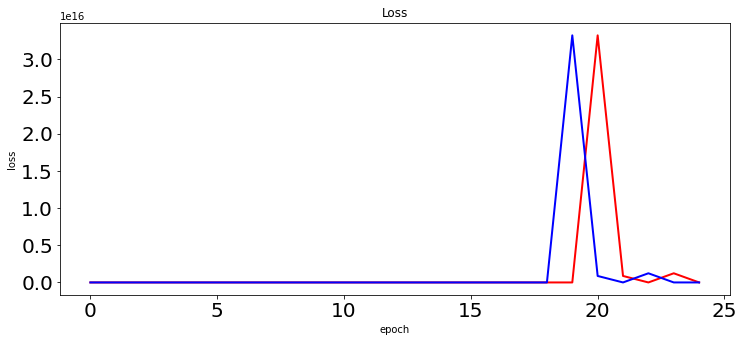

In [109]:
losses = pd.DataFrame([train_losses, test_losses]).T
losses.columns = ["train", "test"]

plt.figure(figsize=(12,5))
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(losses.index, losses["train"], 'r', linewidth=2.0)
plt.plot(losses.index, losses["test"], 'b', linewidth=2.0)

In [111]:
losses.head(20)

,train,test
0,4.197306e+08,3.778084e+08
1,3.778084e+08,3.770497e+08
2,3.770497e+08,3.789884e+08
3,3.789884e+08,2.637453e+08
4,2.637453e+08,4.787233e+08
5,4.787233e+08,3.794217e+08
6,3.794217e+08,3.789352e+08
7,3.789352e+08,1.546358e+09
8,1.546358e+09,3.672537e+09
9,3.672537e+09,3.360882e+10
